In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, 
                                     Dropout, GRU, Bidirectional, BatchNormalization, Input, TimeDistributed)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [6]:
# Step 1: Data Loading and Preprocessing
def preprocess_image(image_path, target_size=(128, 32)):
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    return img_array

# Adjust dataset paths and load data
root_path = r'C:\Users\hp\Desktop\athees half\archive (4)'
csv_path = os.path.join(root_path, 'kan_labels.csv')
data = pd.read_csv(csv_path)
data['Image_Path'] = data['Image_Path'].apply(lambda x: os.path.join(root_path, x))
data['Processed_Images'] = data['Image_Path'].apply(preprocess_image)

In [12]:
# Check if labels are being fetched
def check_labels(data):
    for i, row in data.iterrows():
        print(f"Label for image {row['Image_Path']}: {row['Label']}")
        if i >= 5:  # Check the first 5 labels
            break
check_labels(data)

Label for image C:\Users\hp\Desktop\athees half\archive (4)\kannada_ocr_images/word_0.png: ಲಕ್ಷ
Label for image C:\Users\hp\Desktop\athees half\archive (4)\kannada_ocr_images/word_1.png: ಮೊಬೈಲ್
Label for image C:\Users\hp\Desktop\athees half\archive (4)\kannada_ocr_images/word_2.png: ಲೈಫ್
Label for image C:\Users\hp\Desktop\athees half\archive (4)\kannada_ocr_images/word_3.png: ಲಕ್ಷ
Label for image C:\Users\hp\Desktop\athees half\archive (4)\kannada_ocr_images/word_4.png: ಮೊಬೈಲ್
Label for image C:\Users\hp\Desktop\athees half\archive (4)\kannada_ocr_images/word_5.png: ಮೊಬೈಲ್


In [13]:
# Encode labels
def encode_label(label, max_len, num_classes):
    encoded = np.zeros((max_len, num_classes))
    for i, char in enumerate(label[:max_len]):
        encoded[i, ord(char) % num_classes] = 1
    return encoded

max_label_len = 32  # Adjusted to match the model's output sequence length
num_classes = 70  # Example: Adjust as needed for Kannada characters
data['Encoded_Labels'] = data['Label'].apply(lambda x: encode_label(x, max_label_len, num_classes))

# Prepare train/test splits
X = np.stack(data['Processed_Images'].values)
y = np.stack(data['Encoded_Labels'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Step 2: Model Definition
def build_model(input_shape, output_size):
    inputs = Input(shape=input_shape)

    # CNN for feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Reshape for RNN
    new_seq_len = input_shape[0] // 4  # Adjust for pooling layers
    num_features = (input_shape[1] // 4) * 64  # Features per timestep after CNN layers
    x = tf.keras.layers.Reshape((new_seq_len, num_features))(x)

    # RNN for sequence modeling
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Output layer
    outputs = TimeDistributed(Dense(output_size, activation='softmax'))(x)

    return Model(inputs, outputs)

input_shape = (128, 32, 1)  # Correct input shape for grayscale images
model = build_model(input_shape=input_shape, output_size=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Ensure labels match output sequence length
def adjust_labels_for_output(y, target_seq_len):
    adjusted_labels = np.zeros((y.shape[0], target_seq_len, y.shape[2]))
    for i in range(y.shape[0]):
        adjusted_labels[i, :min(y.shape[1], target_seq_len), :] = y[i, :target_seq_len, :]
    return adjusted_labels

y_train_adjusted = adjust_labels_for_output(y_train, 32)  # Match output sequence length
y_test_adjusted = adjust_labels_for_output(y_test, 32)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 32, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 32, 70)         │        17,990 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,246 (2.02 MB)

 Trainable params: 530,054 (2.02 MB)

 Non-trainable params: 192 (768.00 B)

In [15]:
# Step 3: Model Training
batch_size = 32
epochs = 30
history = model.fit(
    x=X_train,
    y=y_train_adjusted,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test_adjusted),
    verbose=2
)  

Epoch 1/30
1250/1250 - 431s - 345ms/step - accuracy: 0.0464 - loss: 0.4033 - val_accuracy: 0.0592 - val_loss: 0.3517
Epoch 2/30
1250/1250 - 381s - 305ms/step - accuracy: 0.0692 - loss: 0.3086 - val_accuracy: 0.0739 - val_loss: 0.2992
Epoch 3/30
1250/1250 - 396s - 316ms/step - accuracy: 0.0803 - loss: 0.2660 - val_accuracy: 0.0706 - val_loss: 0.3108
Epoch 4/30
1250/1250 - 340s - 272ms/step - accuracy: 0.0872 - loss: 0.2394 - val_accuracy: 0.0838 - val_loss: 0.2588
Epoch 5/30
1250/1250 - 335s - 268ms/step - accuracy: 0.0927 - loss: 0.2189 - val_accuracy: 0.0872 - val_loss: 0.2485
Epoch 6/30
1250/1250 - 336s - 269ms/step - accuracy: 0.0969 - loss: 0.2030 - val_accuracy: 0.0883 - val_loss: 0.2440
Epoch 7/30
1250/1250 - 335s - 268ms/step - accuracy: 0.1008 - loss: 0.1885 - val_accuracy: 0.0904 - val_loss: 0.2406
Epoch 8/30
1250/1250 - 374s - 299ms/step - accuracy: 0.1039 - loss: 0.1769 - val_accuracy: 0.0878 - val_loss: 0.2557
Epoch 9/30
1250/1250 - 451s - 361ms/step - accuracy: 0.1065 - lo

In [3]:
# Step 4: Save the Model (Recommended Keras format)
model_save_path = "athees.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

NameError: name 'model' is not defined

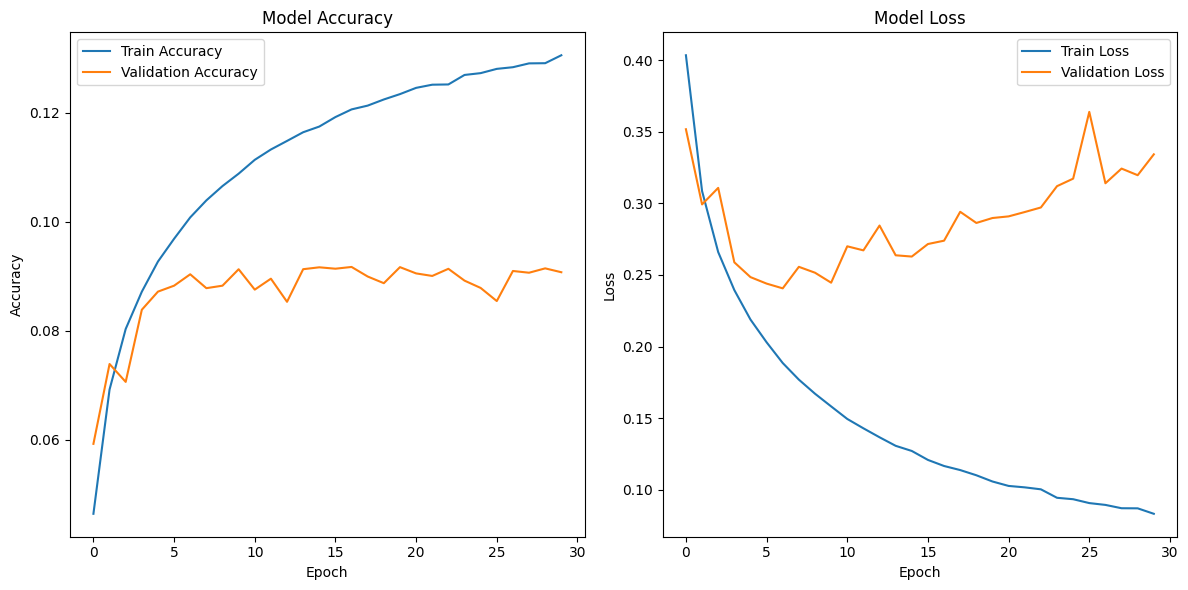

In [17]:
# Step 5: Display Accuracy and Loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import nbformat

# Assuming other necessary imports and model training steps are already in place

def test_model_with_images(model, test_images, test_labels, label_map, num_tests=5):
    """
    Tests the model on a subset of test images and prints the predicted and true labels.

    Parameters:
    - model: Trained Keras model.
    - test_images: Array of test images.
    - test_labels: Array of true labels (one-hot encoded).
    - label_map: Dictionary mapping label indices to characters.
    - num_tests: Number of test samples to evaluate.
    """
    predictions = model.predict(test_images[:num_tests])

    for i in range(num_tests):
        # Get the predicted sequence
        predicted_sequence = np.argmax(predictions[i], axis=-1)
        
        # Decode the true label
        true_label_idx = np.argmax(test_labels[i])  # Extract index if labels are one-hot encoded
        true_label = label_map.get(true_label_idx, "Unknown")

        # Extract only the first predicted character
        if predicted_sequence.size > 0:
            first_pred_idx = predicted_sequence[0]
            predicted_label = label_map.get(first_pred_idx, "Unknown")
        else:
            predicted_label = "No Prediction"

        # Print the predicted and true labels
        print(f"Test {i + 1}:")
        print(f"  Predicted: {predicted_label}")
        print(f"  True: {true_label}\n")

# Prepare test data and label map
label_map = {idx: char for idx, char in enumerate(label_encoder.classes_)}
X_test_subset = X_test[:5]  # Processed test images
y_test_subset = y_test[:5]  # Corresponding true labels

# Test the model
test_model_with_images(model, X_test_subset, y_test_subset, label_map, num_tests=5)



ModuleNotFoundError: No module named 'nbformat'

In [22]:
# Step 3: Preprocessing Images
def preprocess_image(image_path, target_size=(128, 32)):
    # Load image, convert to grayscale, resize and normalize
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

data['Processed_Images'] = data['Image_Path'].apply(preprocess_image)


In [23]:
# Step 4: Encoding Labels

from tensorflow.keras.layers import StringLookup
# Extract unique characters from the labels
characters = sorted(set("".join(data['Label'])))
char_to_num = StringLookup(vocabulary=characters, num_oov_indices=1, mask_token=None)
num_to_char = StringLookup(vocabulary=characters, invert=True, mask_token=None)

def encode_labels(text):
    return char_to_num(tf.strings.unicode_split(text, input_encoding="UTF-8"))

data['Encoded_Labels'] = data['Label'].apply(encode_labels)

In [24]:
# # Step 5: Preparing Data for Training
# X = np.stack(data['Processed_Images'].values)
# X = X.reshape(-1, 32, 128, 1)  # Ensure proper shape for CNN

# def pad_sequences(sequences, maxlen):
#     return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding='post')

# max_label_len = max(data['Encoded_Labels'].apply(lambda x: len(x)).values)
# y = pad_sequences(data['Encoded_Labels'], maxlen=max_label_len)
# Step 5: Preparing Data for Training
X = np.stack(data['Processed_Images'].values)
X = X.reshape(-1, 32, 128, 1)  # Ensure proper shape for CNN

def pad_sequences(sequences, maxlen):
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding='post')

max_label_len = max(data['Encoded_Labels'].apply(lambda x: len(x)).values)
y = pad_sequences(data['Encoded_Labels'], maxlen=max_label_len)

# Convert 3D image to 2D
def convert_3d_to_2d(image):
    return np.max(image, axis=2)

X_train_2d = np.array([convert_3d_to_2d(image) for image in X])
X_train_2d = X_train_2d.reshape(-1, 32, 128)

# One-hot encode the labels
num_classes = len(characters) + 1  # +1 for the blank token
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)



In [25]:
# Split into train/test
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Step 2: Model Definition
def build_model(input_shape, output_size):
    inputs = Input(shape=input_shape)

    # CNN for feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Reshape for RNN
    new_seq_len = input_shape[0] // 4  # Adjust for pooling layers
    num_features = (input_shape[1] // 4) * 64  # Features per timestep after CNN layers
    x = tf.keras.layers.Reshape((new_seq_len, num_features))(x)

    # RNN for sequence modeling
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Output layer
    outputs = TimeDistributed(Dense(output_size, activation='softmax'))(x)

    return Model(inputs, outputs)

input_shape = (128, 32, 1)  # Correct input shape for grayscale images
model = build_model(input_shape=input_shape, output_size=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Ensure labels match output sequence length
def adjust_labels_for_output(y, target_seq_len):
    adjusted_labels = np.zeros((y.shape[0], target_seq_len, y.shape[2]))
    for i in range(y.shape[0]):
        adjusted_labels[i, :min(y.shape[1], target_seq_len), :] = y[i, :target_seq_len, :]
    return adjusted_labels

y_train_adjusted = adjust_labels_for_output(y_train, 32)  # Match output sequence length
y_test_adjusted = adjust_labels_for_output(y_test, 32)

NameError: name 'num_classes' is not defined

In [4]:
# Step 3: Model Training
batch_size = 32
epochs = 10
history = model.fit(
    x=X_train,
    y=y_train_adjusted,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test_adjusted),
    verbose=2
)

NameError: name 'model' is not defined

In [ ]:
# Step 4: Save the Model (Recommended Keras format)
model_save_path = "handwriting_recognition_model.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

NameError: name 'y_train_final' is not defined

In [ ]:
# Step 5: Display Accuracy and Loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import copy
import nbformat
from sklearn.preprocessing import LabelEncoder

# Assuming other necessary imports and model training steps are already in place

def test_model_with_images(model, test_images, test_labels, label_map, num_tests=5):
    """
    Tests the model on a subset of test images and prints the predicted and true labels.

    Parameters:
    - model: Trained Keras model.
    - test_images: Array of test images.
    - test_labels: Array of true labels (one-hot encoded).
    - label_map: Dictionary mapping label indices to characters.
    - num_tests: Number of test samples to evaluate.
    """
    predictions = model.predict(test_images[:num_tests])

    for i in range(num_tests):
        # Get the predicted sequence
        predicted_sequence = np.argmax(predictions[i], axis=-1)
        
        # Decode the true label
        true_label_idx = np.argmax(test_labels[i])  # Extract index if labels are one-hot encoded
        true_label = label_map.get(true_label_idx, "Unknown")

        # Extract only the first predicted character
        if predicted_sequence.size > 0:
            first_pred_idx = predicted_sequence[0]
            predicted_label = label_map.get(first_pred_idx, "Unknown")
        else:
            predicted_label = "No Prediction"

        # Print the predicted and true labels
        print(f"Test {i + 1}:")
        print(f"  Predicted: {predicted_label}")
        print(f"  True: {true_label}\n")

# Prepare test data and label map
label_encoder = LabelEncoder()
unique_labels=data['Label'].unique()
label_encoder.fit(unique_labels)
label_map = {idx: char for idx, char in enumerate(label_encoder.classes_)}
X_test_subset = X_test[:10]  # Processed test images
y_test_subset = y_test[:10]  # Corresponding true labels

# Test the model
test_model_with_images(model, X_test_subset, y_test_subset, label_map, num_tests=5)